<a href="https://colab.research.google.com/github/svvuae/Python_Study/blob/main/SEE912_Q2_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**Download training and testing dataset from google drive**

In [2]:
import gdown
folder_id = '1sR02CtcPKx5ulQ8o0Y7598IbwvUF4kT0'
gdown.download_folder(id=folder_id, quiet=False, output="dataset")

Retrieving folder contents


Processing file 1FAjxELjsNOLt3PH045XtkWDbTV8IDIV_ test.zip
Processing file 19TVvS6Rp-KaSG20MTKOKhxaGIk4hao_Y train.zip


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1FAjxELjsNOLt3PH045XtkWDbTV8IDIV_
To: /content/dataset/test.zip
100%|██████████| 6.28M/6.28M [00:00<00:00, 30.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=19TVvS6Rp-KaSG20MTKOKhxaGIk4hao_Y
From (redirected): https://drive.google.com/uc?id=19TVvS6Rp-KaSG20MTKOKhxaGIk4hao_Y&confirm=t&uuid=8d6c93e3-5c31-4efe-8c77-3ea9dff7007b
To: /content/dataset/train.zip
100%|██████████| 44.2M/44.2M [00:00<00:00, 52.5MB/s]
Download completed


['dataset/test.zip', 'dataset/train.zip']

**Extracting downloaded training and testing dataset zip files**

In [3]:
import zipfile
def extract_zip(zip_file_path, extract_to='.'):
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)
zip_file_path = '/content/dataset/test.zip'
extract_zip(zip_file_path, './dataset')
zip_file_path = '/content/dataset/train.zip'
extract_zip(zip_file_path, './dataset')

In [4]:
import pathlib
test_solar_dir = pathlib.Path('/content/dataset/test/solar')
test_solar = list(test_solar_dir.glob('*.jpg'))
test_nosolar_dir = pathlib.Path('/content/dataset/test/nosolar')
test_nosolar = list(test_nosolar_dir.glob('*.jpg'))
test_dir = pathlib.Path('/content/dataset/test')

112


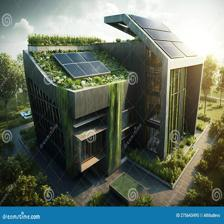

In [5]:
print(len(test_solar))
PIL.Image.open(str(test_solar[0]))

200


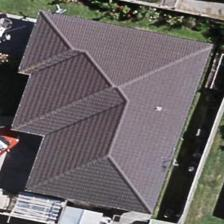

In [6]:
print(len(test_nosolar))
PIL.Image.open(str(test_nosolar[0]))

In [7]:
train_solar_dir = pathlib.Path('/content/dataset/train/solar')
train_solar = list(train_solar_dir.glob('*.jpg'))
train_nosolar_dir = pathlib.Path('/content/dataset/train/nosolar')
train_nosolar = list(train_nosolar_dir.glob('*.jpg'))
train_dir = pathlib.Path('/content/dataset/train')


523


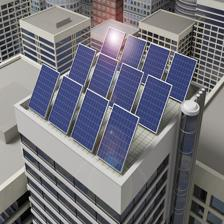

In [8]:
print(len(train_solar))
PIL.Image.open(str(train_solar[0]))

900


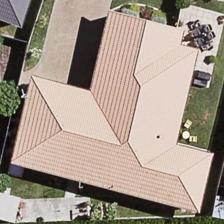

In [9]:
print(len(train_nosolar))
PIL.Image.open(str(train_nosolar[0]))

In [10]:
img_height = 224
img_width = 224
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
    )
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
    )

Found 1800 files belonging to 2 classes.
Found 400 files belonging to 2 classes.


In [11]:
classnames = train_ds.class_names
print(classnames)

['nosolar', 'solar']


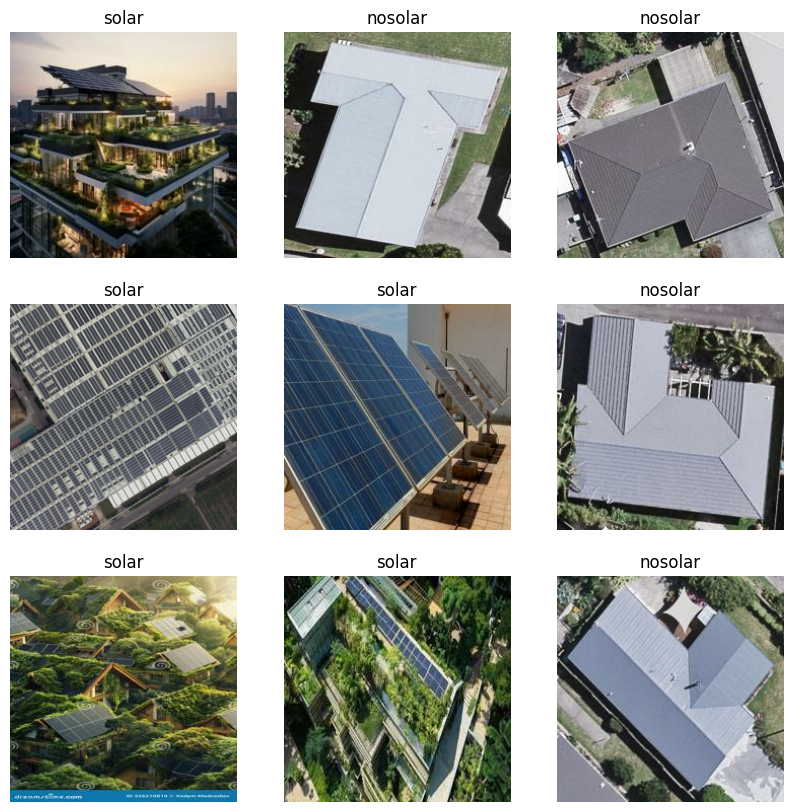

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classnames[labels[i]])
    plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


**Tuning to improve performance**

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Training dataset Normalization**

In [15]:
normalization_layer = layers.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


**1. Training using normal multilayer perceptron (MLP)**

In [17]:
model = keras.Sequential(
    [
        keras.Input(shape=(224, 224, 3)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ]
)

In [18]:
import time
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
start_time = time.time()
history = model.fit(train_ds, epochs=10, validation_data=test_ds)
end_time = time.time()
training_time = end_time - start_time
test_loss, test_acc = model.evaluate(test_ds)
model.summary()
print("Test accuracy:", test_acc)
print("Training time:", training_time)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 414ms/step - accuracy: 0.6301 - loss: 4352.1875 - val_accuracy: 0.9100 - val_loss: 23.6012
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 406ms/step - accuracy: 0.8616 - loss: 34.5008 - val_accuracy: 0.9325 - val_loss: 12.3591
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 409ms/step - accuracy: 0.9278 - loss: 14.4911 - val_accuracy: 0.8925 - val_loss: 25.0836
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 409ms/step - accuracy: 0.8884 - loss: 24.6476 - val_accuracy: 0.9175 - val_loss: 21.4600
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 420ms/step - accuracy: 0.9132 - loss: 19.6180 - val_accuracy: 0.9100 - val_loss: 22.5051
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 412ms/step - accuracy: 0.9106 - loss: 20.0856 - val_accuracy: 0.9750 - val_loss: 7.0891
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 393ms/step - accuracy: 0.9145 - loss: 34.1255 - val_accuracy: 0.9200 - val_loss: 26.7995
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 402ms/step - accuracy: 0.9375 - loss: 19

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      19,267,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,803,525 (220.50 MB)

 Trainable params: 19,267,841 (73.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,535,684 (147.00 MB)

Test accuracy: 0.862500011920929
Training time: 338.914737701416


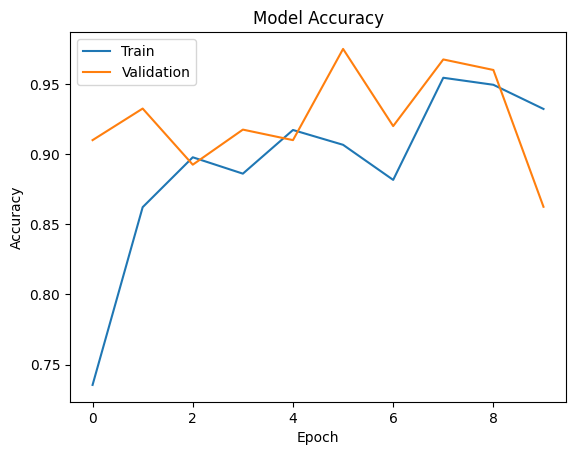

Average Training Time per Epoch: 33.8914737701416


In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
epochs = len(history.history['accuracy'])
time_per_epoch = training_time / epochs
print("Average Training Time per Epoch:", time_per_epoch)

**2. Training using CNN with only 1 hidden layers**

In [20]:
model = keras.Sequential(
    [
        keras.Input(shape=(224, 224, 3)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ]
)

In [21]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
start_time = time.time()
history = model.fit(train_ds, epochs=10, validation_data=test_ds)
end_time = time.time()
training_time = end_time - start_time
test_loss, test_acc = model.evaluate(test_ds)
model.summary()
print("Test accuracy:", test_acc)
print("Training time:", training_time)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.6800 - loss: 995.8809 - val_accuracy: 0.9850 - val_loss: 3.2403
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9778 - loss: 5.5241 - val_accuracy: 0.9700 - val_loss: 5.3374
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9768 - loss: 3.3347 - val_accuracy: 0.9950 - val_loss: 1.4342
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9960 - loss: 0.7449 - val_accuracy: 0.9950 - val_loss: 1.6488
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9957 - loss: 0.4547 - val_accuracy: 0.9925 - val_loss: 1.4892
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9997 - loss: 0.0311 - val_accuracy: 0.9925 - val_loss: 0.4789
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9969 - loss: 0.0980 - val_accuracy: 0.9925 - val_loss: 1.5773
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9998 - loss: 0.0129 - val_accuracy: 0.9950 - val_los

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 394272)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │         394,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,185,509 (4.52 MB)

 Trainable params: 395,169 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 790,340 (3.01 MB)

Test accuracy: 0.9925000071525574
Training time: 760.8159244060516


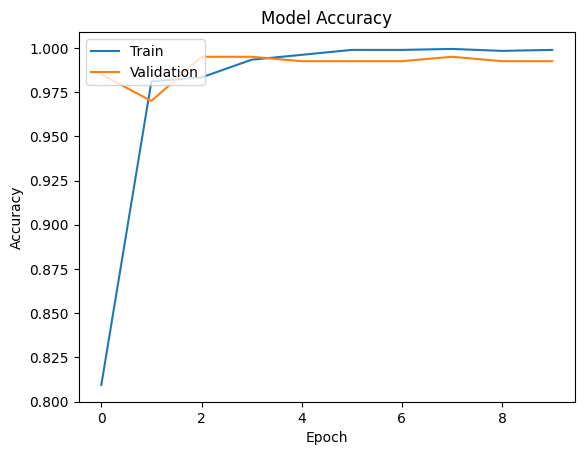

Average Training Time per Epoch: 76.08159244060516


In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
epochs = len(history.history['accuracy'])
time_per_epoch = training_time / epochs
print("Average Training Time per Epoch:", time_per_epoch)

**3. Training using CNN with multiple hidden layers**

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.6230 - loss: 846.4970 - val_accuracy: 0.9825 - val_loss: 2.1196
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9854 - loss: 1.0212 - val_accuracy: 0.9850 - val_loss: 1.1087
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9947 - loss: 0.3114 - val_accuracy: 0.9900 - val_loss: 0.2106
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9925 - loss: 0.3148 - val_accuracy: 0.9975 - val_loss: 0.0742
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9967 - loss: 0.1912 - val_accuracy: 0.9850 - val_loss: 0.4592
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9962 - loss: 0.0776 - val_accuracy: 0.9900 - val_loss: 0.4754
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9999 - loss: 0.0049 - val_accuracy: 0.9900 - val_loss: 0.3913
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9996 - loss: 0.0034 - val_accuracy: 0.9925 - val_los

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 394272)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │         394,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,185,509 (4.52 MB)

 Trainable params: 395,169 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 790,340 (3.01 MB)

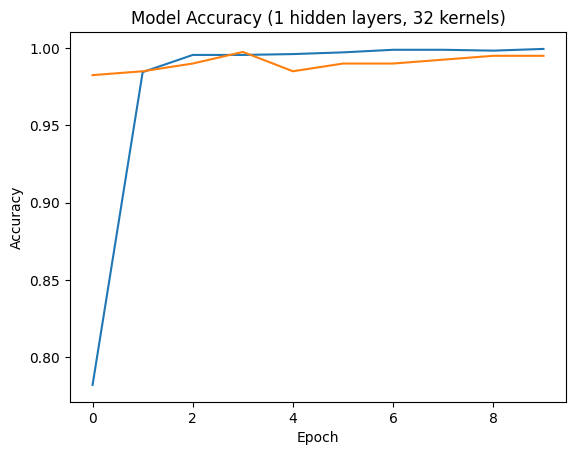

Average Training Time per Epoch: 74.28030126094818
Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 274s 5s/step - accuracy: 0.7169 - loss: 90.9804 - val_accuracy: 0.9950 - val_loss: 0.0342
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 282s 5s/step - accuracy: 0.9829 - loss: 0.0498 - val_accuracy: 0.9775 - val_loss: 0.0478
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 271s 5s/step - accuracy: 0.9838 - loss: 0.0522 - val_accuracy: 0.9900 - val_loss: 0.0433
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 272s 5s/step - accuracy: 0.9935 - loss: 0.0139 - val_accuracy: 0.9850 - val_loss: 0.0560
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 322s 5s/step - accuracy: 0.9947 - loss: 0.0175 - val_accuracy: 0.9875 - val_loss: 0.0499
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 268s 5s/step - accuracy: 0.9792 - loss: 0.1490 - val_accuracy: 0.9900 - val_loss: 0.0497
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 322s 5s/step - accuracy: 0.9960 - loss: 0.0134 - val_accuracy: 0.9700 - val_loss: 0.0897
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 269s 5s/step - accura

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 109, 109, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │         186,625 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 676,037 (2.58 MB)

 Trainable params: 225,345 (880.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 450,692 (1.72 MB)

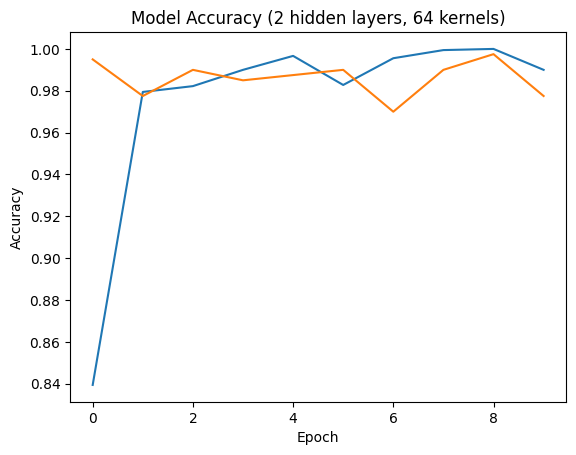

Average Training Time per Epoch: 292.38139827251433
Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 806s 14s/step - accuracy: 0.6831 - loss: 26.5607 - val_accuracy: 0.9975 - val_loss: 0.0112
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 787s 14s/step - accuracy: 0.9829 - loss: 0.0698 - val_accuracy: 0.9975 - val_loss: 0.0075
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 787s 14s/step - accuracy: 0.9942 - loss: 0.0179 - val_accuracy: 0.9825 - val_loss: 0.0304
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 785s 14s/step - accuracy: 0.9915 - loss: 0.0269 - val_accuracy: 0.9900 - val_loss: 0.0260
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 788s 14s/step - accuracy: 0.9894 - loss: 0.0600 - val_accuracy: 0.9875 - val_loss: 0.0310
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 786s 14s/step - accuracy: 0.9849 - loss: 0.0476 - val_accuracy: 0.9950 - val_loss: 0.0187
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 826s 15s/step - accuracy: 0.9965 - loss: 0.0075 - val_accuracy: 0.9850 - val_loss: 0.0809
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 823s 14s/step

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 52, 52, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │          86,529 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,155,845 (4.41 MB)

 Trainable params: 385,281 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 770,564 (2.94 MB)

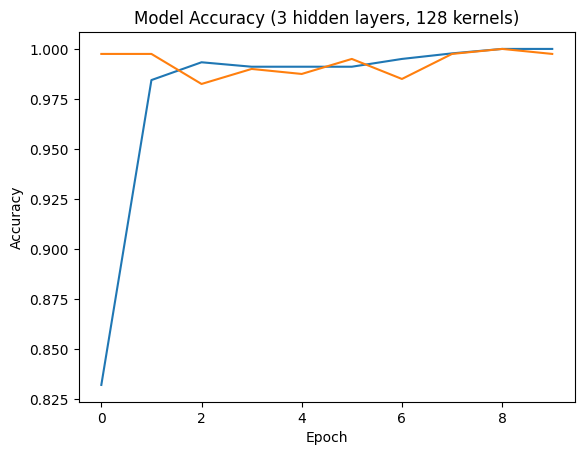

Average Training Time per Epoch: 799.7935854434967


In [23]:
def create_and_train_cnn(num_hidden_layers, num_kernels):
    model = keras.Sequential()
    model.add(keras.Input(shape=(224, 224, 3)))
    for i in range(num_hidden_layers):
        model.add(layers.Conv2D(num_kernels, kernel_size=(3, 3), activation="relu"))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    start_time = time.time()
    history = model.fit(train_ds, epochs=10, validation_data=test_ds)
    end_time = time.time()
    training_time = end_time - start_time
    model.summary()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model Accuracy ({num_hidden_layers} hidden layers, {num_kernels} kernels)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()
    epochs = len(history.history['accuracy'])
    time_per_epoch = training_time / epochs
    print("Average Training Time per Epoch:", time_per_epoch)

configurations = [
    (1, 32),  # 1 hidden layer, 32 kernels
    (2, 64),  # 2 hidden layers, 64 kernels
    (3, 128)  # 3 hidden layers, 128 kernels
]

for num_hidden_layers, num_kernels in configurations:
    create_and_train_cnn(num_hidden_layers, num_kernels)

**4. Training using ResNet50**


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 424s 7s/step - accuracy: 0.8515 - loss: 0.3600 - val_accuracy: 0.9900 - val_loss: 0.0427
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 454s 8s/step - accuracy: 0.9956 - loss: 0.0346 - val_accuracy: 1.0000 - val_loss: 0.0227
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 439s 7s/step - accuracy: 0.9984 - loss: 0.0208 - val_accuracy: 1.0000 - val_loss: 0.0154
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 411s 7s/step - accuracy: 0.9987 - loss: 0.0152 - val_accuracy: 1.0000 - val_loss: 0.0116
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 412s 7s/step - accuracy: 0.9999 - loss: 0.0100 - val_accuracy: 1.0000 - val_loss: 0.0092
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 417s 7s/step - accuracy: 0.9999 - loss: 0.0079 - val_accuracy: 1.0000 - val_loss: 0.0079
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 413s 7s/step - accuracy: 1.0000 - loss: 0.0074 - val_accuracy: 1.0000 - val_loss: 0.0064
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 420s 7s/step - accurac

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,593,861 (90.00 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 4,100 (16.02 KB)

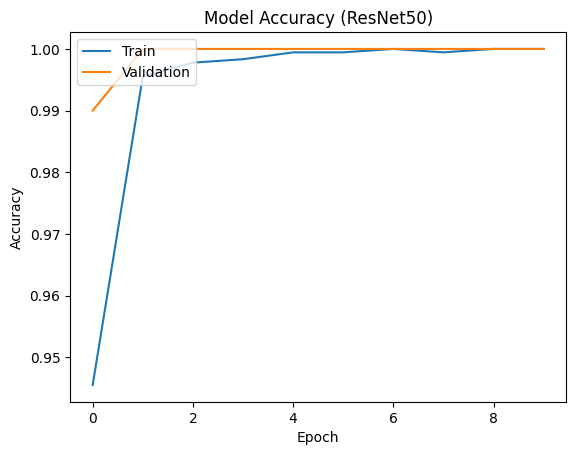

Average Training Time per Epoch: 425.5267008781433


In [24]:
base_model = keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
start_time = time.time()
history = model.fit(train_ds, epochs=10, validation_data=test_ds)

end_time = time.time()
training_time = end_time - start_time
model.summary()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy (ResNet50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

epochs = len(history.history['accuracy'])
time_per_epoch = training_time / epochs
print("Average Training Time per Epoch:", time_per_epoch)